https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://github.com/ogniandantchev/dilated_causal_cnn_time_series/blob/00116a919725633f1b19d776e8fd4bdb934591c8/02_GRU_RNN_model.ipynb
# Multivariate Time Series Forecasting with LSTMs in Keras

## Dataset
This is a dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.

Beijing PM2.5 Data Set (rename to raw.csv)

https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv

In [1]:
from datetime import datetime

from math import sqrt

from pandas import read_csv, DataFrame, concat

from numpy import concatenate

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU

from matplotlib import pyplot

In [2]:
# Load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

In [3]:
dataset = read_csv('raw.csv', parse_dates=[['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)

In [4]:
dataset

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,43820,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,43821,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,43822,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [5]:
dataset.drop('No', axis=1, inplace=True)

In [6]:
# Manually specify column names
dataset.columns =['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name ='date'

In [7]:
# Mark all N.A. values with 0
dataset['pollution'].fillna(0, inplace=True)

In [8]:
# Drop the first 24 hours
dataset = dataset[24:]

In [9]:
# Summarize first 5 rows
print(dataset.head(5))

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [10]:
# Save to file
dataset.to_csv('pollution.csv')

## Process the new dataset

In [11]:
# Load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

In [12]:
# Specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1

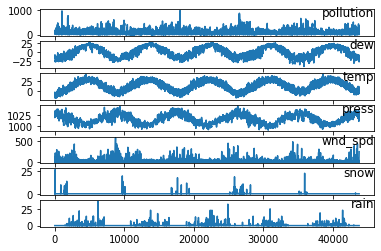

In [13]:
# Plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

## Prepare data for the LSTM

In [14]:
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # Input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # Forecast sequence
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # Put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [15]:
# Load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

In [16]:
# Integer encode direction
encoder = LabelEncoder()
values[:, 4] = encoder.fit_transform(values[:, 4])

In [17]:
# Ensure all data is float
values = values.astype('float32')

In [18]:
# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [19]:
# Frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [20]:
# Drop the columns not to be predicted
reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


## Define and fit the model

In [21]:
# Split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [22]:
# Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [23]:
# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [24]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((8760, 1, 8), (8760,), (35039, 1, 8), (35039,))

In [25]:
# Design network
model = Sequential()
model.add(GRU(units=512,
              return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1, activation="tanh"))
model.compile(loss='mae', optimizer='adam')

In [26]:
# Fit network
history = model.fit(train_X, train_y, 
                    epochs=50, batch_size=72, 
                    validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)

Epoch 1/50
122/122 - 2s - loss: 0.0400 - val_loss: 0.0429
Epoch 2/50
122/122 - 2s - loss: 0.0180 - val_loss: 0.0195
Epoch 3/50
122/122 - 2s - loss: 0.0167 - val_loss: 0.0246
Epoch 4/50
122/122 - 2s - loss: 0.0168 - val_loss: 0.0248
Epoch 5/50
122/122 - 2s - loss: 0.0160 - val_loss: 0.0209
Epoch 6/50
122/122 - 2s - loss: 0.0158 - val_loss: 0.0200
Epoch 7/50
122/122 - 2s - loss: 0.0150 - val_loss: 0.0170
Epoch 8/50
122/122 - 2s - loss: 0.0158 - val_loss: 0.0239
Epoch 9/50
122/122 - 2s - loss: 0.0163 - val_loss: 0.0191
Epoch 10/50
122/122 - 2s - loss: 0.0152 - val_loss: 0.0216
Epoch 11/50
122/122 - 2s - loss: 0.0154 - val_loss: 0.0234
Epoch 12/50
122/122 - 2s - loss: 0.0155 - val_loss: 0.0186
Epoch 13/50
122/122 - 2s - loss: 0.0162 - val_loss: 0.0158
Epoch 14/50
122/122 - 2s - loss: 0.0172 - val_loss: 0.0154
Epoch 15/50
122/122 - 2s - loss: 0.0155 - val_loss: 0.0136
Epoch 16/50
122/122 - 2s - loss: 0.0147 - val_loss: 0.0138
Epoch 17/50
122/122 - 2s - loss: 0.0158 - val_loss: 0.0141
Epoch 

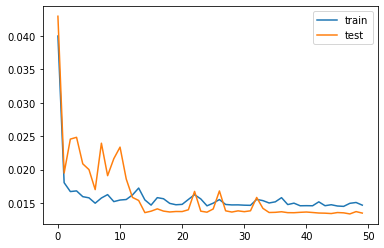

In [27]:
# Plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Evaluate model

In [28]:
# Make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [29]:
yhat.shape

(35039, 1, 1)

In [30]:
# Invert scaling for forecast
inv_yhat = concatenate((yhat[:,:,0], test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

In [31]:
# Invert scaling for actual
test_y = test_y.reshape(len(test_y), 1)
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

In [32]:
# Calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
rmse

26.41861766586208